In [1]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from skimage import io
import cv2

import math
import pickle

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

ModuleNotFoundError: No module named 'pandas'

Exploss minimize the similarity of samples with different labels

In [31]:
class ExpLoss(nn.Module):
    def __init__(self, depth):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        
        att = sims
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
#         mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [18]:
feature = torch.rand(12, 64, 24, 24)
labels = torch.randint(0,7,(12,))

feat, sims = ExpLoss(64)(feature, labels)
feat.size(), sims

feature.device

NameError: name 'att' is not defined

In [119]:
labels = torch.randint(0,7,(12,))
print(labels)
mask = torch.ones(len(labels), len(labels))

tensor([1, 2, 3, 0, 4, 2, 4, 3, 5, 1, 2, 3])


## Compare between the original VGG and VGG with Exploss on top of last conv

### Viz embedding function and confusion matrix

In [31]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

label_dict={0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

def visualize_embedding(features, labels, label_dict=None, save_path=None):
    if label_dict is None:
        str_labels = labels
    else:
        str_labels = [label_dict[k] for k in labels]

    tsne_features = TSNE(n_components=2).fit_transform(features)
    fig, ax = plt.subplots(figsize=(15,10))
    sns.scatterplot(ax=ax, x=tsne_features[:,0], y=tsne_features[:,1], 
                    hue=str_labels, style=str_labels, palette="deep")

    if save_path is not None:
        fig.savefig(save_path)

    return fig, tsne_features


def visualize_cm(cm, save_path=None, str_labels=None):
    
    fig, ax = plt.subplots(figsize=(15,10))
    xticklabels = str_labels if str_labels is not None else 'auto'
    yticklabels = str_labels if str_labels is not None else 'auto'
    sns.heatmap(cm, vmin=0, vmax=1, ax=ax, annot=True, xticklabels=xticklabels, yticklabels=yticklabels)

    if save_path is not None:
        fig.savefig(save_path)

    return fig

### Data loader

In [2]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [25]:
batch_size= 64

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

# train_set = FERDataset(df_train, train_transforms)
# val_set = FERDataset(df_val, test_transforms)
# test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

### Original VGG

In [5]:
from torchvision.models import vgg16_bn

In [4]:
class sVGG(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, return_att=True):
        x = self.features(x)
        att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, att
        return x
        

In [6]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [7]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [53]:
MAX_LOGSTD=10
model_path = 'exploss/sVGG_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, features = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, features = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.6415150165557861 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:24<00:00, 18.26it/s]

- Avg.loss: 1.7669 | Avg.acc: 0.2706


- Avg. val_loss: 1.7286 | Avg. val_acc: 0.2979


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.458497166633606 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:24<00:00, 18.17it/s]

- Avg.loss: 1.6271 | Avg.acc: 0.3442


- Avg. val_loss: 1.5605 | Avg. val_acc: 0.3884


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.382860541343689 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 1.4619 | Avg.acc: 0.4193


- Avg. val_loss: 1.4249 | Avg. val_acc: 0.4505


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.611953616142273 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 1.4059 | Avg.acc: 0.4484



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5743 | Avg. val_acc: 0.3954
Epoch:  5


Loss=1.4721899032592773 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:24<00:00, 18.10it/s]

- Avg.loss: 1.3620 | Avg.acc: 0.4704



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6513 | Avg. val_acc: 0.3508
Epoch:  6


Loss=1.434408187866211 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 1.3169 | Avg.acc: 0.4881


- Avg. val_loss: 1.2727 | Avg. val_acc: 0.5096


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.652871012687683 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 1.2629 | Avg.acc: 0.5150


- Avg. val_loss: 1.2435 | Avg. val_acc: 0.5255


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.4707417488098145 Batch_id=448 Accuracy=0.2972972972972973: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 1.2217 | Avg.acc: 0.5330


- Avg. val_loss: 1.1816 | Avg. val_acc: 0.5422


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.3637670278549194 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 1.1847 | Avg.acc: 0.5479



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2660 | Avg. val_acc: 0.5185
Epoch:  10


Loss=1.3713581562042236 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 1.1559 | Avg.acc: 0.5623


- Avg. val_loss: 1.1331 | Avg. val_acc: 0.5715


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.0609935522079468 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 1.1292 | Avg.acc: 0.5763


- Avg. val_loss: 1.1199 | Avg. val_acc: 0.5723


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.1159241199493408 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 1.1018 | Avg.acc: 0.5926


- Avg. val_loss: 1.0962 | Avg. val_acc: 0.5790


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=0.9815379977226257 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 1.0775 | Avg.acc: 0.5961


- Avg. val_loss: 1.1232 | Avg. val_acc: 0.5904


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.1782104969024658 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 1.0550 | Avg.acc: 0.6098


- Avg. val_loss: 1.0996 | Avg. val_acc: 0.5968


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=0.9940284490585327 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 1.0346 | Avg.acc: 0.6212


- Avg. val_loss: 1.0848 | Avg. val_acc: 0.6057


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.3473104238510132 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 1.0096 | Avg.acc: 0.6303



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0800 | Avg. val_acc: 0.6046
Epoch:  17


Loss=1.2980468273162842 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:24<00:00, 17.99it/s]

- Avg.loss: 0.9905 | Avg.acc: 0.6393


- Avg. val_loss: 1.1026 | Avg. val_acc: 0.6071


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.4353692531585693 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 0.9633 | Avg.acc: 0.6496



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0677 | Avg. val_acc: 0.6002
Epoch:  19


Loss=1.4330978393554688 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 0.9403 | Avg.acc: 0.6586


- Avg. val_loss: 1.0594 | Avg. val_acc: 0.6094


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.7568204998970032 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 0.9233 | Avg.acc: 0.6670


- Avg. val_loss: 1.0244 | Avg. val_acc: 0.6308


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  21


Loss=0.7505547404289246 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8909 | Avg.acc: 0.6796



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1020 | Avg. val_acc: 0.6016
Epoch:  22


Loss=0.8522161245346069 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8781 | Avg.acc: 0.6827



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1642 | Avg. val_acc: 0.5809
Epoch:  23


Loss=0.8443782329559326 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8548 | Avg.acc: 0.6919



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0140 | Avg. val_acc: 0.6278
Epoch:  24


Loss=0.8577458262443542 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.04it/s]

- Avg.loss: 0.8303 | Avg.acc: 0.7006



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0524 | Avg. val_acc: 0.6261
Epoch:  25


Loss=0.7764689922332764 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.8133 | Avg.acc: 0.7093


- Avg. val_loss: 1.0073 | Avg. val_acc: 0.6425


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  26


Loss=0.7781779766082764 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 0.7880 | Avg.acc: 0.7202



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1481 | Avg. val_acc: 0.6135
Epoch:  27


Loss=0.645167350769043 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 0.7682 | Avg.acc: 0.7268


- Avg. val_loss: 1.0377 | Avg. val_acc: 0.6428


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.7925492525100708 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 0.7518 | Avg.acc: 0.7331


- Avg. val_loss: 1.0277 | Avg. val_acc: 0.6492


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.8646169900894165 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.7253 | Avg.acc: 0.7447



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0500 | Avg. val_acc: 0.6369
Epoch:  30


Loss=0.93306565284729 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 0.7061 | Avg.acc: 0.7522



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0809 | Avg. val_acc: 0.6308
Epoch:  31


Loss=0.6142908334732056 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.6800 | Avg.acc: 0.7586



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0996 | Avg. val_acc: 0.6333
Epoch:  32


Loss=0.9189328551292419 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]

- Avg.loss: 0.6762 | Avg.acc: 0.7639



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0612 | Avg. val_acc: 0.6408
Epoch:  33


Loss=0.43351414799690247 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.12it/s]

- Avg.loss: 0.6609 | Avg.acc: 0.7686



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0872 | Avg. val_acc: 0.6425
Epoch:  34


Loss=0.6267328262329102 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 0.6337 | Avg.acc: 0.7785


- Avg. val_loss: 1.1156 | Avg. val_acc: 0.6509


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=0.5245478749275208 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.01it/s]

- Avg.loss: 0.6257 | Avg.acc: 0.7797



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1472 | Avg. val_acc: 0.6381
Epoch:  36


Loss=0.3473629355430603 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.10it/s]

- Avg.loss: 0.5973 | Avg.acc: 0.7943



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1796 | Avg. val_acc: 0.6439
Epoch:  37


Loss=0.4919716715812683 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.02it/s]

- Avg.loss: 0.5922 | Avg.acc: 0.7965



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1394 | Avg. val_acc: 0.6422
Epoch:  38


Loss=1.0571610927581787 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 0.5721 | Avg.acc: 0.8007



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2113 | Avg. val_acc: 0.6411
Epoch:  39


Loss=0.6597703695297241 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 0.5616 | Avg.acc: 0.8055



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2096 | Avg. val_acc: 0.6445
Epoch:  40


Loss=0.5175756216049194 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.14it/s]

- Avg.loss: 0.5540 | Avg.acc: 0.8078



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1984 | Avg. val_acc: 0.6369
Epoch    40: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  41


Loss=0.5288664102554321 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.08it/s]


- Avg.loss: 0.4246 | Avg.acc: 0.8567
- Avg. val_loss: 1.2265 | Avg. val_acc: 0.6760


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  42


Loss=0.5021191835403442 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:24<00:00, 18.05it/s]

- Avg.loss: 0.3766 | Avg.acc: 0.8732



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2818 | Avg. val_acc: 0.6743
Epoch:  43


Loss=0.34123024344444275 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.14it/s]

- Avg.loss: 0.3496 | Avg.acc: 0.8841



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3124 | Avg. val_acc: 0.6746
Epoch:  44


Loss=0.2570284903049469 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.15it/s]

- Avg.loss: 0.3408 | Avg.acc: 0.8866



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3275 | Avg. val_acc: 0.6748
Epoch:  45


Loss=0.4755467474460602 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.10it/s]

- Avg.loss: 0.3202 | Avg.acc: 0.8935



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3618 | Avg. val_acc: 0.6748
Epoch:  46


Loss=0.48369598388671875 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.09it/s]

- Avg.loss: 0.3132 | Avg.acc: 0.8942



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3972 | Avg. val_acc: 0.6751
Epoch:  47


Loss=0.5158913135528564 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.12it/s]

- Avg.loss: 0.3056 | Avg.acc: 0.9004



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3984 | Avg. val_acc: 0.6729
Epoch    47: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  48


Loss=0.20605722069740295 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:24<00:00, 18.03it/s]

- Avg.loss: 0.2994 | Avg.acc: 0.8994



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4195 | Avg. val_acc: 0.6760
Epoch:  49


Loss=0.4238435924053192 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.07it/s]

- Avg.loss: 0.2825 | Avg.acc: 0.9046



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.4190 | Avg. val_acc: 0.6754
Epoch:  50


Loss=0.23128357529640198 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.06it/s]

- Avg.loss: 0.2869 | Avg.acc: 0.9043


- Avg. val_loss: 1.4273 | Avg. val_acc: 0.6734
Finished Training


In [54]:
pickle.dump(hist, open('exploss/sVGG_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7f31d24ff320>,
 0.6759543048202842)

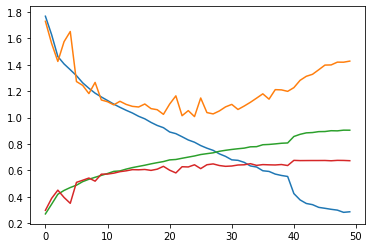

In [55]:
plt.plot(hist), best_acc

In [14]:
# test
model = torch.load('exploss/sVGG_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(val_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, features = model(inputs)

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.2265 | Avg. val_acc: 0.6760


In [37]:
MAX_LOGSTD=10
model_path = 'exploss/sVGG_reconfirm_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, features = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, features = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5092052221298218 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:24<00:00, 18.39it/s]

- Avg.loss: 1.7557 | Avg.acc: 0.2776



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7802 | Avg. val_acc: 0.2510
* Update optimal model
Epoch:  2


Loss=1.4560662508010864 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:24<00:00, 18.32it/s]

- Avg.loss: 1.5479 | Avg.acc: 0.3891


- Avg. val_loss: 1.7395 | Avg. val_acc: 0.3516


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.3366326093673706 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 1.4362 | Avg.acc: 0.4386


- Avg. val_loss: 1.3756 | Avg. val_acc: 0.4698


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.2695608139038086 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 1.3802 | Avg.acc: 0.4656



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3819 | Avg. val_acc: 0.4689
Epoch:  5


Loss=1.1450906991958618 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 1.3313 | Avg.acc: 0.4859


- Avg. val_loss: 1.2990 | Avg. val_acc: 0.4887


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.244624376296997 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:24<00:00, 18.24it/s]

- Avg.loss: 1.2723 | Avg.acc: 0.5131


- Avg. val_loss: 1.2177 | Avg. val_acc: 0.5311


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=1.2999883890151978 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 1.2274 | Avg.acc: 0.5310



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2599 | Avg. val_acc: 0.5124
Epoch:  8


Loss=0.9905573725700378 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.24it/s]

- Avg.loss: 1.1992 | Avg.acc: 0.5451



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2402 | Avg. val_acc: 0.5255
Epoch:  9


Loss=1.4925580024719238 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 1.1660 | Avg.acc: 0.5566


- Avg. val_loss: 1.1392 | Avg. val_acc: 0.5670


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.0395255088806152 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.25it/s]

- Avg.loss: 1.1499 | Avg.acc: 0.5664



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1720 | Avg. val_acc: 0.5511
Epoch:  11


Loss=1.2532908916473389 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.24it/s]

- Avg.loss: 1.1180 | Avg.acc: 0.5793


- Avg. val_loss: 1.1139 | Avg. val_acc: 0.5762


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.1819144487380981 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 1.0975 | Avg.acc: 0.5923



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1601 | Avg. val_acc: 0.5695
Epoch:  13


Loss=1.0432459115982056 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:24<00:00, 18.26it/s]

- Avg.loss: 1.0738 | Avg.acc: 0.6005


- Avg. val_loss: 1.0726 | Avg. val_acc: 0.5993


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.0215656757354736 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.24it/s]

- Avg.loss: 1.0569 | Avg.acc: 0.6145



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0848 | Avg. val_acc: 0.5918
Epoch:  15


Loss=0.9533098340034485 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.26it/s]

- Avg.loss: 1.0277 | Avg.acc: 0.6236



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1022 | Avg. val_acc: 0.5965
Epoch:  16


Loss=0.884117841720581 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 1.0066 | Avg.acc: 0.6353



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0730 | Avg. val_acc: 0.5943
Epoch:  17


Loss=0.7234866619110107 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 0.9882 | Avg.acc: 0.6413


- Avg. val_loss: 1.0623 | Avg. val_acc: 0.6066


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=0.9606374502182007 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:24<00:00, 18.31it/s]

- Avg.loss: 0.9629 | Avg.acc: 0.6488


- Avg. val_loss: 1.0565 | Avg. val_acc: 0.6085


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=0.9942984580993652 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.28it/s]

- Avg.loss: 0.9401 | Avg.acc: 0.6597


- Avg. val_loss: 1.0339 | Avg. val_acc: 0.6149


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.928863525390625 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.30it/s]

- Avg.loss: 0.9247 | Avg.acc: 0.6638



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0436 | Avg. val_acc: 0.6088
Epoch:  21


Loss=0.8645896911621094 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.26it/s]

- Avg.loss: 0.9044 | Avg.acc: 0.6732


- Avg. val_loss: 1.0166 | Avg. val_acc: 0.6314


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=0.6843583583831787 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 0.8798 | Avg.acc: 0.6820


- Avg. val_loss: 0.9893 | Avg. val_acc: 0.6364


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.9378864169120789 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.26it/s]

- Avg.loss: 0.8690 | Avg.acc: 0.6870



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0304 | Avg. val_acc: 0.6278
Epoch:  24


Loss=1.035207986831665 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:24<00:00, 18.25it/s]

- Avg.loss: 0.8427 | Avg.acc: 0.6958



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0391 | Avg. val_acc: 0.6211
Epoch:  25


Loss=1.079185128211975 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:24<00:00, 18.30it/s]

- Avg.loss: 0.8241 | Avg.acc: 0.7053



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0429 | Avg. val_acc: 0.6336
Epoch:  26


Loss=0.8133836984634399 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 0.8038 | Avg.acc: 0.7127


- Avg. val_loss: 1.0267 | Avg. val_acc: 0.6431


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.7881706357002258 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 0.7875 | Avg.acc: 0.7198



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0059 | Avg. val_acc: 0.6389
Epoch:  28


Loss=0.7657103538513184 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:24<00:00, 18.31it/s]

- Avg.loss: 0.7642 | Avg.acc: 0.7279



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0554 | Avg. val_acc: 0.6358
Epoch:  29


Loss=0.8375157713890076 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 0.7469 | Avg.acc: 0.7354



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0811 | Avg. val_acc: 0.6241
Epoch:  30


Loss=0.7812553644180298 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:24<00:00, 18.30it/s]

- Avg.loss: 0.7252 | Avg.acc: 0.7416



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0764 | Avg. val_acc: 0.6275
Epoch:  31


Loss=0.778869092464447 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 0.7098 | Avg.acc: 0.7519



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0821 | Avg. val_acc: 0.6239
Epoch:  32


Loss=1.4820624589920044 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:24<00:00, 18.30it/s]

- Avg.loss: 0.6952 | Avg.acc: 0.7550



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0889 | Avg. val_acc: 0.6336
Epoch    32: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  33


Loss=0.44672903418540955 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.23it/s]

- Avg.loss: 0.5549 | Avg.acc: 0.8102


- Avg. val_loss: 1.0581 | Avg. val_acc: 0.6687


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  34


Loss=0.6116719841957092 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:24<00:00, 18.28it/s]

- Avg.loss: 0.4990 | Avg.acc: 0.8295


- Avg. val_loss: 1.1158 | Avg. val_acc: 0.6729


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=0.4384549558162689 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.26it/s]

- Avg.loss: 0.4711 | Avg.acc: 0.8387



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1434 | Avg. val_acc: 0.6665
Epoch:  36


Loss=0.2556666135787964 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.25it/s]

- Avg.loss: 0.4498 | Avg.acc: 0.8466


- Avg. val_loss: 1.1451 | Avg. val_acc: 0.6787


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=0.6333163380622864 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.30it/s]

- Avg.loss: 0.4319 | Avg.acc: 0.8528



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2187 | Avg. val_acc: 0.6721
Epoch:  38


Loss=0.7816041111946106 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:24<00:00, 18.32it/s]

- Avg.loss: 0.4221 | Avg.acc: 0.8553



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2029 | Avg. val_acc: 0.6695
Epoch:  39


Loss=0.5798845887184143 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:24<00:00, 18.31it/s]

- Avg.loss: 0.4049 | Avg.acc: 0.8607



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2332 | Avg. val_acc: 0.6721
Epoch:  40


Loss=0.42720627784729004 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.33it/s]

- Avg.loss: 0.3962 | Avg.acc: 0.8663



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2543 | Avg. val_acc: 0.6695
Epoch:  41


Loss=0.37954169511795044 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 0.3853 | Avg.acc: 0.8702



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2591 | Avg. val_acc: 0.6640
Epoch:  42


Loss=0.17046542465686798 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 0.3759 | Avg.acc: 0.8733



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2938 | Avg. val_acc: 0.6656
Epoch    42: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  43


Loss=0.4473193883895874 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 0.3506 | Avg.acc: 0.8841



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2891 | Avg. val_acc: 0.6679
Epoch:  44


Loss=0.3247048258781433 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:24<00:00, 18.33it/s]

- Avg.loss: 0.3573 | Avg.acc: 0.8801



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2943 | Avg. val_acc: 0.6682
Epoch:  45


Loss=0.14654234051704407 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:24<00:00, 18.29it/s]

- Avg.loss: 0.3431 | Avg.acc: 0.8849



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3066 | Avg. val_acc: 0.6673
Epoch:  46


Loss=0.32765132188796997 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:24<00:00, 18.30it/s]

- Avg.loss: 0.3488 | Avg.acc: 0.8824



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3015 | Avg. val_acc: 0.6709
Epoch:  47


Loss=0.31914404034614563 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:24<00:00, 18.28it/s]

- Avg.loss: 0.3423 | Avg.acc: 0.8871



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3234 | Avg. val_acc: 0.6668
Epoch:  48


Loss=0.23297645151615143 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:24<00:00, 18.32it/s]

- Avg.loss: 0.3444 | Avg.acc: 0.8829



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3129 | Avg. val_acc: 0.6676
Epoch    48: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  49


Loss=0.4340183734893799 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:24<00:00, 18.32it/s]

- Avg.loss: 0.3424 | Avg.acc: 0.8860



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3239 | Avg. val_acc: 0.6712
Epoch:  50


Loss=0.19816428422927856 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:24<00:00, 18.27it/s]

- Avg.loss: 0.3414 | Avg.acc: 0.8852


- Avg. val_loss: 1.3103 | Avg. val_acc: 0.6704
Finished Training


### VGG with exploss

In [16]:
class sVGG_exp(nn.Module):
    def __init__(self, features, in_features_classifier, n_classes):
        super(sVGG_exp, self).__init__()
        self.features = features
        self.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.exploss = ExpLoss(512)
#         self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(in_features_classifier, in_features_classifier),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier, in_features_classifier // 2),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(in_features_classifier // 2, n_classes))
        
    def forward(self, x, labels, return_att=True):
        x = self.features(x)
        att, sim_loss = self.exploss(x, labels)

#         att = self.avgpool(x)
        x = self.classifier(att)
        
        if return_att:
            return x, sim_loss, att
        return x, sim_loss
        

In [17]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

NameError: name 'ExpLoss' is not defined

In [ ]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [46]:
MAX_LOGSTD=10
model_path = 'exploss/sVGG_exploss_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8796675205230713 Batch_id=448 Accuracy=0.16216216216216217: 100%|██████████| 449/449 [00:24<00:00, 18.10it/s]

- Avg.loss: 1.8076 | Avg.acc: 0.2464


- Avg. val_loss: 1.8012 | Avg. val_acc: 0.2580


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.9455665349960327 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:24<00:00, 17.97it/s]

- Avg.loss: 1.7209 | Avg.acc: 0.2957



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.7865 | Avg. val_acc: 0.1686
Epoch:  3


Loss=1.6065689325332642 Batch_id=448 Accuracy=0.32432432432432434: 100%|██████████| 449/449 [00:24<00:00, 17.96it/s]

- Avg.loss: 1.6824 | Avg.acc: 0.3124


- Avg. val_loss: 1.6483 | Avg. val_acc: 0.3246


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.409362554550171 Batch_id=448 Accuracy=0.4594594594594595: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]

- Avg.loss: 1.6498 | Avg.acc: 0.3270



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.4406 | Avg. val_acc: 0.2494
Epoch:  5


Loss=1.4719817638397217 Batch_id=448 Accuracy=0.4864864864864865: 100%|██████████| 449/449 [00:25<00:00, 17.92it/s]

- Avg.loss: 1.5268 | Avg.acc: 0.3916


- Avg. val_loss: 1.4984 | Avg. val_acc: 0.3962


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.5609952211380005 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:25<00:00, 17.81it/s]

- Avg.loss: 1.4477 | Avg.acc: 0.4190



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 4.1598 | Avg. val_acc: 0.3051
Epoch:  7


Loss=1.6686303615570068 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:25<00:00, 17.92it/s]

- Avg.loss: 1.4137 | Avg.acc: 0.4335


- Avg. val_loss: 1.4247 | Avg. val_acc: 0.4330


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.4047352075576782 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:25<00:00, 17.83it/s]

- Avg.loss: 1.3868 | Avg.acc: 0.4425


- Avg. val_loss: 1.3830 | Avg. val_acc: 0.4441


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.6526553630828857 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:25<00:00, 17.86it/s]

- Avg.loss: 1.3699 | Avg.acc: 0.4454


- Avg. val_loss: 1.3747 | Avg. val_acc: 0.4614


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.4642341136932373 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:25<00:00, 17.87it/s]

- Avg.loss: 1.3391 | Avg.acc: 0.4560



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5294 | Avg. val_acc: 0.4101
Epoch:  11


Loss=1.282388687133789 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 1.3044 | Avg.acc: 0.4734



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 3.0253 | Avg. val_acc: 0.3895
Epoch:  12


Loss=1.2580413818359375 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]

- Avg.loss: 1.2832 | Avg.acc: 0.4875



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.6853 | Avg. val_acc: 0.4475
Epoch:  13


Loss=0.9432674050331116 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 1.2613 | Avg.acc: 0.5085


- Avg. val_loss: 1.3051 | Avg. val_acc: 0.5046


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=1.148837685585022 Batch_id=448 Accuracy=0.5675675675675675: 100%|██████████| 449/449 [00:25<00:00, 17.88it/s]

- Avg.loss: 1.2183 | Avg.acc: 0.5319



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5267 | Avg. val_acc: 0.4996
Epoch:  15


Loss=1.0813794136047363 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:25<00:00, 17.92it/s]

- Avg.loss: 1.1890 | Avg.acc: 0.5438



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.8659 | Avg. val_acc: 0.4681
Epoch:  16


Loss=1.106995940208435 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:25<00:00, 17.93it/s]

- Avg.loss: 1.1568 | Avg.acc: 0.5584


- Avg. val_loss: 1.2129 | Avg. val_acc: 0.5453


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=1.0275764465332031 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 1.1372 | Avg.acc: 0.5660


- Avg. val_loss: 1.1629 | Avg. val_acc: 0.5623


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.0780051946640015 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 1.1161 | Avg.acc: 0.5771



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1605 | Avg. val_acc: 0.5603
Epoch:  19


Loss=1.125720500946045 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:25<00:00, 17.88it/s]

- Avg.loss: 1.0946 | Avg.acc: 0.5849



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1836 | Avg. val_acc: 0.5489
Epoch:  20


Loss=0.7541094422340393 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:25<00:00, 17.93it/s]

- Avg.loss: 1.0871 | Avg.acc: 0.5911



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3051 | Avg. val_acc: 0.5492
Epoch:  21


Loss=1.0225820541381836 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]

- Avg.loss: 1.0615 | Avg.acc: 0.6052



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2813 | Avg. val_acc: 0.5570
Epoch:  22


Loss=1.0074667930603027 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]

- Avg.loss: 1.0492 | Avg.acc: 0.6101


- Avg. val_loss: 1.1508 | Avg. val_acc: 0.5834


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  23


Loss=0.7388501763343811 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:25<00:00, 17.82it/s]

- Avg.loss: 1.0302 | Avg.acc: 0.6220



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2413 | Avg. val_acc: 0.5428
Epoch:  24


Loss=1.2610737085342407 Batch_id=448 Accuracy=0.5135135135135135: 100%|██████████| 449/449 [00:25<00:00, 17.95it/s]

- Avg.loss: 1.0148 | Avg.acc: 0.6242



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5023 | Avg. val_acc: 0.5350
Epoch:  25


Loss=1.3592469692230225 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:25<00:00, 17.90it/s]

- Avg.loss: 1.0098 | Avg.acc: 0.6285



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2244 | Avg. val_acc: 0.5692
Epoch:  26


Loss=1.023398995399475 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:25<00:00, 17.87it/s]

- Avg.loss: 0.9895 | Avg.acc: 0.6379



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2859 | Avg. val_acc: 0.5592
Epoch:  27


Loss=0.9403278231620789 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:25<00:00, 17.88it/s]

- Avg.loss: 0.9818 | Avg.acc: 0.6457



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1702 | Avg. val_acc: 0.5787
Epoch:  28


Loss=0.7718905806541443 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:25<00:00, 17.90it/s]

- Avg.loss: 0.9716 | Avg.acc: 0.6508


- Avg. val_loss: 1.1204 | Avg. val_acc: 0.5901


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  29


Loss=0.8659768104553223 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:25<00:00, 17.92it/s]


- Avg.loss: 0.9503 | Avg.acc: 0.6565


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5588 | Avg. val_acc: 0.5322
Epoch:  30


Loss=0.7924603223800659 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]

- Avg.loss: 0.9397 | Avg.acc: 0.6618


- Avg. val_loss: 1.1416 | Avg. val_acc: 0.5993


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  31


Loss=0.9659520983695984 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:25<00:00, 17.90it/s]

- Avg.loss: 0.9338 | Avg.acc: 0.6632



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2044 | Avg. val_acc: 0.5829
Epoch:  32


Loss=0.9469431042671204 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:25<00:00, 17.88it/s]

- Avg.loss: 0.9175 | Avg.acc: 0.6710



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2321 | Avg. val_acc: 0.5991
Epoch:  33


Loss=0.7073619961738586 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:25<00:00, 17.92it/s]

- Avg.loss: 0.9159 | Avg.acc: 0.6753



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1567 | Avg. val_acc: 0.5991
Epoch:  34


Loss=0.7212584018707275 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:25<00:00, 17.84it/s]

- Avg.loss: 0.8904 | Avg.acc: 0.6852



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2002 | Avg. val_acc: 0.5965
Epoch:  35


Loss=1.2083101272583008 Batch_id=448 Accuracy=0.5945945945945946: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]


- Avg.loss: 0.8894 | Avg.acc: 0.6821


  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1879 | Avg. val_acc: 0.5960
Epoch:  36


Loss=0.8370166420936584 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 0.8702 | Avg.acc: 0.6921


- Avg. val_loss: 1.2025 | Avg. val_acc: 0.6027


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  37


Loss=0.725313663482666 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 0.8691 | Avg.acc: 0.6928



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1422 | Avg. val_acc: 0.6024
Epoch:  38


Loss=0.7858384847640991 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:25<00:00, 17.96it/s]

- Avg.loss: 0.8545 | Avg.acc: 0.6969



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1297 | Avg. val_acc: 0.5954
Epoch:  39


Loss=0.8514143228530884 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:25<00:00, 17.93it/s]

- Avg.loss: 0.8384 | Avg.acc: 0.7060


- Avg. val_loss: 1.1566 | Avg. val_acc: 0.6152


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=0.7891450524330139 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 0.8329 | Avg.acc: 0.7089



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2214 | Avg. val_acc: 0.6133
Epoch:  41


Loss=0.8432364463806152 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:25<00:00, 17.91it/s]

- Avg.loss: 0.8305 | Avg.acc: 0.7103



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.9035 | Avg. val_acc: 0.5258
Epoch:  42


Loss=0.8935118913650513 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:25<00:00, 17.92it/s]

- Avg.loss: 0.8199 | Avg.acc: 0.7157


- Avg. val_loss: 1.2167 | Avg. val_acc: 0.6199


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  43


Loss=0.5643364191055298 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]

- Avg.loss: 0.8025 | Avg.acc: 0.7238



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5118 | Avg. val_acc: 0.5784
Epoch:  44


Loss=1.1741206645965576 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:25<00:00, 17.89it/s]

- Avg.loss: 0.7929 | Avg.acc: 0.7250



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1662 | Avg. val_acc: 0.6094
Epoch:  45


Loss=0.6957641243934631 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:25<00:00, 17.90it/s]

- Avg.loss: 0.7994 | Avg.acc: 0.7241



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2140 | Avg. val_acc: 0.6085
Epoch:  46


Loss=0.8994011878967285 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:25<00:00, 17.84it/s]

- Avg.loss: 0.7865 | Avg.acc: 0.7296



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1689 | Avg. val_acc: 0.6160
Epoch:  47


Loss=0.7856957912445068 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:25<00:00, 17.87it/s]

- Avg.loss: 0.7682 | Avg.acc: 0.7365



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2896 | Avg. val_acc: 0.6055
Epoch:  48


Loss=0.7638568878173828 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:25<00:00, 17.88it/s]

- Avg.loss: 0.7620 | Avg.acc: 0.7396



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1445 | Avg. val_acc: 0.6110
Epoch    48: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  49


Loss=0.9795635342597961 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:25<00:00, 17.88it/s]

- Avg.loss: 0.6626 | Avg.acc: 0.7804


- Avg. val_loss: 1.2245 | Avg. val_acc: 0.6328


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  50


Loss=0.4519929587841034 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:25<00:00, 17.87it/s]

- Avg.loss: 0.6196 | Avg.acc: 0.7960


- Avg. val_loss: 1.2271 | Avg. val_acc: 0.6319
Finished Training


In [48]:
pickle.dump(hist, open('exploss/sVGG_exploss_hist.hdf5', 'wb'))

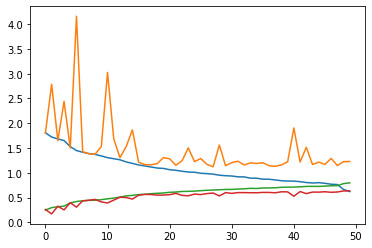

In [47]:
plt.plot(hist)

**Why the attention mechanism did not work in the last conv layer?**

The issue comes from Sigmoid activation. Here are some comments of mine

1. The sigmoid activation function limit the range of sims matrix from 0 to 1, which is not a large range enough to make the feature learn from this attention map

2. When release the Sigmoid, the model start learning gradually. However, comparing with the original version of sVGG, the model has slower learning.

3. Without any activation function for attention map, the model seems to be very sensitive and start overfitting after only 3 - 4 epochs (which is disapointed me alot :(

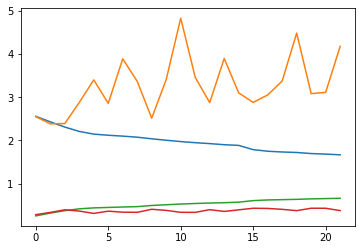

> What is the reason? 
1. Due to the sim_loss is not effective? --> remove the effect of sims loss: the model learn better than (4) and not identify the overfitting yet. However, the learning process is fluctuated
2. The way we produce the last feature is the problem?
3. No activation function?: using activation functions does not help the model learning
4. Due to the out_fc (too much fc layer?) --> Remove out_fc: model does not learn at all!


4. Try RELU activation for attention map: the same as problem (1)

**--> Apply the activation function for attention map cause the problem**


### Compare the training progress

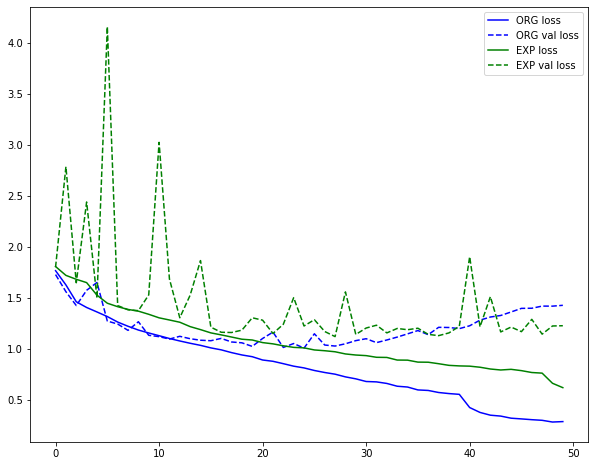

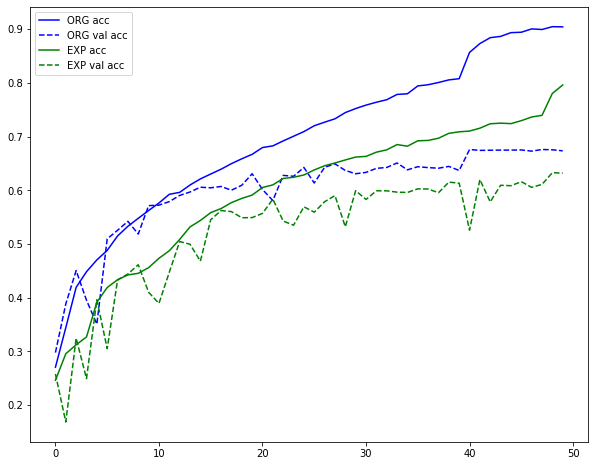

In [16]:
original = pickle.load(open('exploss/sVGG_hist.hdf5' ,'rb'))
exp = pickle.load(open('exploss/sVGG_exploss_hist.hdf5', 'rb'))

# loss
plt.figure(figsize=(10,8))
plt.plot([k[0] for k in original], 'b-', label='ORG loss')
plt.plot([k[1] for k in original], 'b--', label='ORG val loss')

plt.plot([k[0] for k in exp], 'g-', label='EXP loss')
plt.plot([k[1] for k in exp], 'g--', label='EXP val loss')

plt.legend()
plt.show()

# accuracy
plt.figure(figsize=(10,8))
plt.plot([k[-2] for k in original], 'b-', label='ORG acc')
plt.plot([k[-1] for k in original], 'b--', label='ORG val acc')

plt.plot([k[-2] for k in exp], 'g-', label='EXP acc')
plt.plot([k[-1] for k in exp], 'g--', label='EXP val acc')

plt.legend()
plt.show()



## Representation

In [50]:
model = torch.load('exploss/sVGG_model.pt')

running_valloss = 0.0
running_valacc = 0.0
org_features = []
org_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs, features = model(inputs)
    
    with torch.no_grad():
        org_features.append(features.detach().cpu().squeeze())
        org_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 1.1224 | Avg. val_acc: 0.6874


In [51]:
model = torch.load('exploss/sVGG_exploss_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 1.1320 | Avg. val_acc: 0.6381


In [52]:
org_features = torch.cat(org_features, axis=0)
org_labels = torch.cat(org_labels)

exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

org_features.size(), exp_features.size()

(torch.Size([3589, 512]), torch.Size([3589, 512]))

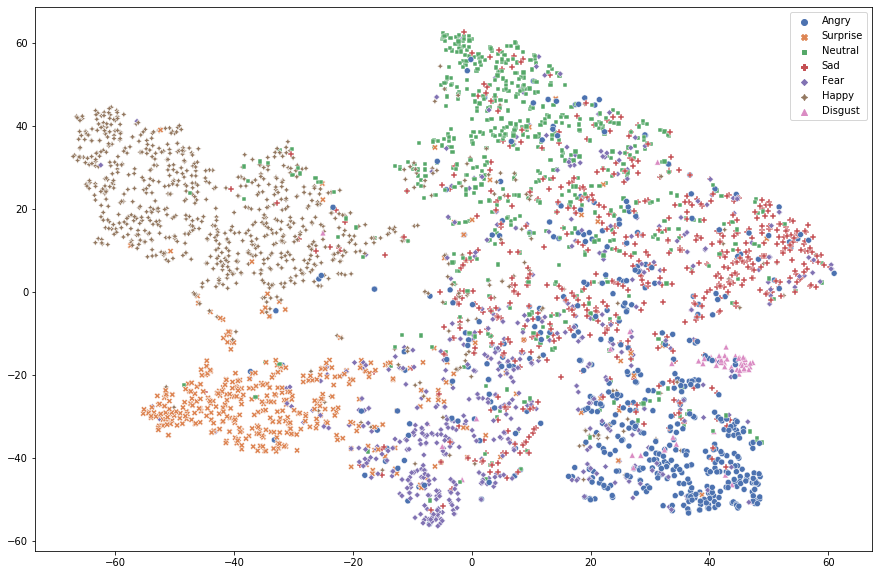

In [62]:
org_fig, org_tsne = visualize_embedding(org_features.numpy(), org_labels.numpy(), label_dict, save_path=None)

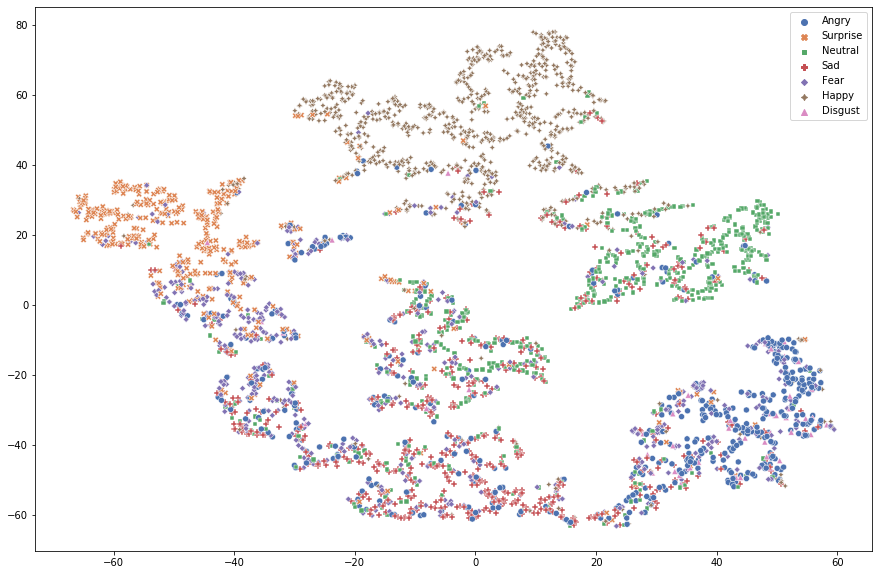

In [63]:
exp_fig, exp_tsne = visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict, save_path=None)

## Exploss: apply mask to only concern data with same labels

Hypothesis: from the representation of exploss, it can be considered that some sample with different labels are closed to the considered one. The reason reflects on the attention map. Particularly, since we consider all samples in the batch of data, some samples with different labels have higher score then the ones with same labels.

To reduce this phenomenom, we tend to apply a mask and only concern samples with the sample labels

> Results:
- Val test: val_loss: 0.3313 | Avg. val_acc: 0.9089
- Test set: test_loss: 0.2685 | Avg. test_acc: 0.9156

In [18]:
class ExpLoss(nn.Module):
    def __init__(self, depth):
        super(ExpLoss, self).__init__()
        
        self.depth = depth
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(depth, depth)
        self.fc2 = nn.Linear(depth, depth)
        
#         self.main_fc = nn.Linear(depth, depth)
        
        self.sim_act = nn.Sigmoid()
        self.att_act = nn.Sigmoid()
        
        self.out_fc = nn.Sequential(nn.Linear(depth, depth),
                                    nn.BatchNorm1d(depth),
                                    nn.ReLU())
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        x = self.avgpool(x)
        x = self.flatten(x)
        
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        
        # cal sims (batchsize, depth)
        sims = torch.mm(x1, x2.permute(1,0))
        sims = sims / batch_size
        mask = self.filter_mask(labels)
        att = sims * (1 - mask.to(sims.device)) # only consider sample of same labels
#         att = self.att_act(sims)
#         print('att after sigmoid: ', att.min(), att.max(), att.mean(), att.var())
        
#         print('att pure: ', sims.min(), sims.max(), sims.mean(), sims.var())
#         att = torch.tanh(sims)
#         print('att after tanh: ', att.min(), att.max(), att.mean(), att.var())
#         att = self.relu(att)
#         print('att after relu: ', att.min(), att.max(), att.mean(), att.var())
# #         print('min: %.4f, max: %.4f, var: %.4f' % (att.min(), att.max(), att.std()))
        
#         x = self.main_fc(x)
        x = torch.mm(att, x)
#         print('x before out_fc: ', x.min(), x.max(), x.mean(), x.var())
        x = self.out_fc(x)
#         print('x after out_fc: ', x.min(), x.max(), x.mean(), x.var())
        
#         print('att: ', att.min(), att.max(), att.mean(), att.var())
        
        
#         # cal sims loss
        mask = self.filter_mask(labels)
#         sims = sims * mask.to(sims.device)


#         # prevent negative value
#         sims = self.sim_act(sims)
        
#         sims = sims.sum()
#         sims = sims / self.depth
        
        return x, 0

    def filter_mask(self, labels):
        """
        zero
        """
        classes = torch.unique(labels)
        mask = torch.ones((len(labels), len(labels)))
        
        indices = [(labels == k).nonzero().flatten() for k in classes]
        lindices = [torch.combinations(k, r=2, with_replacement=True) for k in indices]
        rindices = [torch.combinations(k.flip(0), r=2, with_replacement=True) for k in indices]
        indices = [torch.cat([lindices[i], rindices[i]]) for i in range(len(lindices))]

        for k in indices:
            mask[k[:,0], k[:,1]] = 0.
            
        return mask

In [19]:
sample_model = vgg16_bn(pretrained=False)
model = sVGG_exp(features=sample_model.features[:34], in_features_classifier=512, n_classes=7)

In [20]:
lr = 0.001
epochs = 50
device = torch.device('cuda')

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

best_acc = 0.0
hist = []

In [22]:
MAX_LOGSTD=10
model_path = 'exploss/sVGG_exploss_samelabelsmask_model.pt'
alpha = 1

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, sim_loss, features = model(inputs, labels)
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.4f | Avg.acc: %.4f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, sim_loss, features = model(inputs, labels)
        
        loss = criterion(outputs, labels) + sim_loss
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')


  0%|          | 0/449 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2742358446121216 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:28<00:00, 15.97it/s]

- Avg.loss: 1.5968 | Avg.acc: 0.3616



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5546 | Avg. val_acc: 0.3642
* Update optimal model
Epoch:  2


Loss=2.9096813201904297 Batch_id=448 Accuracy=0.24324324324324326: 100%|██████████| 449/449 [00:28<00:00, 15.97it/s]

- Avg.loss: 1.3583 | Avg.acc: 0.4617



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.7679 | Avg. val_acc: 0.3335
Epoch:  3


Loss=1.0474742650985718 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:28<00:00, 15.92it/s]

- Avg.loss: 1.2015 | Avg.acc: 0.5096


- Avg. val_loss: 1.0205 | Avg. val_acc: 0.5709


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.2778279781341553 Batch_id=448 Accuracy=0.43243243243243246: 100%|██████████| 449/449 [00:28<00:00, 15.92it/s]

- Avg.loss: 1.0485 | Avg.acc: 0.5632



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.3700 | Avg. val_acc: 0.5138
Epoch:  5


Loss=0.6814874410629272 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:28<00:00, 15.87it/s]

- Avg.loss: 0.9217 | Avg.acc: 0.6118


- Avg. val_loss: 0.9274 | Avg. val_acc: 0.6297


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.6489607095718384 Batch_id=448 Accuracy=0.2702702702702703: 100%|██████████| 449/449 [00:28<00:00, 15.88it/s]

- Avg.loss: 0.8449 | Avg.acc: 0.6515



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1076 | Avg. val_acc: 0.5968
Epoch:  7


Loss=1.119442343711853 Batch_id=448 Accuracy=0.5405405405405406: 100%|██████████| 449/449 [00:28<00:00, 15.94it/s]

- Avg.loss: 0.8051 | Avg.acc: 0.6756



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1394 | Avg. val_acc: 0.6155
Epoch:  8


Loss=0.6863173246383667 Batch_id=448 Accuracy=0.6486486486486487: 100%|██████████| 449/449 [00:28<00:00, 15.90it/s]

- Avg.loss: 0.7529 | Avg.acc: 0.6992



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.5529 | Avg. val_acc: 0.5684
Epoch:  9


Loss=0.4825819432735443 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:28<00:00, 15.90it/s]

- Avg.loss: 0.7062 | Avg.acc: 0.7305



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.6994 | Avg. val_acc: 0.4263
Epoch:  10


Loss=1.9534801244735718 Batch_id=448 Accuracy=0.40540540540540543: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.6220 | Avg.acc: 0.7601


- Avg. val_loss: 0.7041 | Avg. val_acc: 0.7052


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.5250118970870972 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:28<00:00, 15.82it/s]

- Avg.loss: 0.5616 | Avg.acc: 0.7869



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.5843 | Avg. val_acc: 0.4263
Epoch:  12


Loss=1.1621450185775757 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:28<00:00, 15.91it/s]

- Avg.loss: 0.5902 | Avg.acc: 0.7759



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.2008 | Avg. val_acc: 0.6525
Epoch:  13


Loss=0.21021875739097595 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.5191 | Avg.acc: 0.7989


- Avg. val_loss: 0.7322 | Avg. val_acc: 0.7169


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.7557080984115601 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:28<00:00, 15.84it/s]

- Avg.loss: 0.4764 | Avg.acc: 0.8203



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1600 | Avg. val_acc: 0.6960
Epoch:  15


Loss=1.1798843145370483 Batch_id=448 Accuracy=0.35135135135135137: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.5305 | Avg.acc: 0.8078


- Avg. val_loss: 0.8891 | Avg. val_acc: 0.7517


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  16


Loss=1.193660020828247 Batch_id=448 Accuracy=0.3783783783783784: 100%|██████████| 449/449 [00:28<00:00, 15.83it/s]

- Avg.loss: 0.4544 | Avg.acc: 0.8249



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.3930 | Avg. val_acc: 0.4425
Epoch:  17


Loss=0.1354251652956009 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:28<00:00, 15.82it/s]      

- Avg.loss: 0.4243 | Avg.acc: 0.8453


- Avg. val_loss: 0.7338 | Avg. val_acc: 0.7562


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=0.9243295192718506 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:28<00:00, 15.87it/s]

- Avg.loss: 0.4448 | Avg.acc: 0.8417



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1160 | Avg. val_acc: 0.7283
Epoch:  19


Loss=0.3671402335166931 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:28<00:00, 15.90it/s]

- Avg.loss: 0.3699 | Avg.acc: 0.8618


- Avg. val_loss: 0.4851 | Avg. val_acc: 0.8289


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  20


Loss=0.32302919030189514 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.3939 | Avg.acc: 0.8660



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.5191 | Avg. val_acc: 0.8189
Epoch:  21


Loss=1.3748726844787598 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:28<00:00, 15.87it/s]

- Avg.loss: 0.3660 | Avg.acc: 0.8707



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.0531 | Avg. val_acc: 0.7033
Epoch:  22


Loss=0.2931964695453644 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:28<00:00, 15.88it/s]

- Avg.loss: 0.4099 | Avg.acc: 0.8572



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.9605 | Avg. val_acc: 0.7047
Epoch:  23


Loss=0.49571964144706726 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:28<00:00, 15.89it/s]

- Avg.loss: 0.3084 | Avg.acc: 0.8961



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 1.1580 | Avg. val_acc: 0.7091
Epoch:  24


Loss=0.3140336275100708 Batch_id=448 Accuracy=0.8378378378378378: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.2944 | Avg.acc: 0.9053



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 2.2543 | Avg. val_acc: 0.6637
Epoch:  25


Loss=0.20099911093711853 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.3090 | Avg.acc: 0.8993



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 8.9165 | Avg. val_acc: 0.2572
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  26


Loss=0.8046965599060059 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:28<00:00, 15.84it/s]

- Avg.loss: 0.2543 | Avg.acc: 0.9117


- Avg. val_loss: 0.4597 | Avg. val_acc: 0.8470


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=0.0176226906478405 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:28<00:00, 15.82it/s]      

- Avg.loss: 0.1903 | Avg.acc: 0.9364


- Avg. val_loss: 0.3562 | Avg. val_acc: 0.9036


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=0.12047535926103592 Batch_id=448 Accuracy=0.972972972972973: 100%|██████████| 449/449 [00:28<00:00, 15.85it/s]

- Avg.loss: 0.1752 | Avg.acc: 0.9410



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4214 | Avg. val_acc: 0.8768
Epoch:  29


Loss=0.8638198375701904 Batch_id=448 Accuracy=0.7567567567567568: 100%|██████████| 449/449 [00:28<00:00, 15.85it/s]

- Avg.loss: 0.1649 | Avg.acc: 0.9431



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3679 | Avg. val_acc: 0.8927
Epoch:  30


Loss=0.3248428702354431 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:28<00:00, 15.81it/s]

- Avg.loss: 0.1473 | Avg.acc: 0.9530



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4038 | Avg. val_acc: 0.8883
Epoch:  31


Loss=0.1902182549238205 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:28<00:00, 15.84it/s]       

- Avg.loss: 0.1451 | Avg.acc: 0.9529



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3451 | Avg. val_acc: 0.9028
Epoch:  32


Loss=0.7901443243026733 Batch_id=448 Accuracy=0.6216216216216216: 100%|██████████| 449/449 [00:28<00:00, 15.88it/s]

- Avg.loss: 0.1349 | Avg.acc: 0.9557



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3745 | Avg. val_acc: 0.8813
Epoch:  33


Loss=0.176763653755188 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:28<00:00, 15.88it/s]

- Avg.loss: 0.1358 | Avg.acc: 0.9564



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3411 | Avg. val_acc: 0.8944
Epoch    33: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  34


Loss=0.44395264983177185 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:28<00:00, 15.92it/s]

- Avg.loss: 0.1361 | Avg.acc: 0.9543



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3641 | Avg. val_acc: 0.8768
Epoch:  35


Loss=0.9064673185348511 Batch_id=448 Accuracy=0.7837837837837838: 100%|██████████| 449/449 [00:28<00:00, 15.84it/s]

- Avg.loss: 0.1367 | Avg.acc: 0.9524



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3543 | Avg. val_acc: 0.8897
Epoch:  36


Loss=0.2575443983078003 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.1143 | Avg.acc: 0.9625



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3413 | Avg. val_acc: 0.8885
Epoch:  37


Loss=0.14339841902256012 Batch_id=448 Accuracy=0.918918918918919: 100%|██████████| 449/449 [00:28<00:00, 15.84it/s]

- Avg.loss: 0.1289 | Avg.acc: 0.9563



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3616 | Avg. val_acc: 0.8805
Epoch:  38


Loss=0.015623693354427814 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:28<00:00, 15.87it/s]     

- Avg.loss: 0.1288 | Avg.acc: 0.9580



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3341 | Avg. val_acc: 0.8919
Epoch:  39


Loss=1.047067642211914 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:28<00:00, 15.80it/s]

- Avg.loss: 0.1260 | Avg.acc: 0.9583



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3351 | Avg. val_acc: 0.9000
Epoch    39: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  40


Loss=0.0031795320101082325 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:28<00:00, 15.87it/s]    

- Avg.loss: 0.1198 | Avg.acc: 0.9604


- Avg. val_loss: 0.3298 | Avg. val_acc: 0.9061


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  41


Loss=0.688510537147522 Batch_id=448 Accuracy=0.6756756756756757: 100%|██████████| 449/449 [00:28<00:00, 15.82it/s]

- Avg.loss: 0.1361 | Avg.acc: 0.9566



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3817 | Avg. val_acc: 0.8716
Epoch:  42


Loss=0.47838515043258667 Batch_id=448 Accuracy=0.8918918918918919: 100%|██████████| 449/449 [00:28<00:00, 15.82it/s]

- Avg.loss: 0.1127 | Avg.acc: 0.9618



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3949 | Avg. val_acc: 0.8716
Epoch:  43


Loss=0.7024879455566406 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.1256 | Avg.acc: 0.9584


- Avg. val_loss: 0.3313 | Avg. val_acc: 0.9089


  0%|          | 0/449 [00:00<?, ?it/s]

* Update optimal model
Epoch:  44


Loss=0.31518077850341797 Batch_id=448 Accuracy=0.8108108108108109: 100%|██████████| 449/449 [00:28<00:00, 15.77it/s]

- Avg.loss: 0.1255 | Avg.acc: 0.9577



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3494 | Avg. val_acc: 0.8969
Epoch:  45


Loss=1.0955270528793335 Batch_id=448 Accuracy=0.7297297297297297: 100%|██████████| 449/449 [00:28<00:00, 15.80it/s]

- Avg.loss: 0.1323 | Avg.acc: 0.9565



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3715 | Avg. val_acc: 0.8919
Epoch:  46


Loss=0.12120139598846436 Batch_id=448 Accuracy=0.9459459459459459: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]

- Avg.loss: 0.1181 | Avg.acc: 0.9619



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3268 | Avg. val_acc: 0.9039
Epoch:  47


Loss=0.9130612015724182 Batch_id=448 Accuracy=0.7027027027027027: 100%|██████████| 449/449 [00:28<00:00, 15.87it/s]

- Avg.loss: 0.1373 | Avg.acc: 0.9530



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3498 | Avg. val_acc: 0.8902
Epoch:  48


Loss=0.4013066291809082 Batch_id=448 Accuracy=0.8648648648648649: 100%|██████████| 449/449 [00:28<00:00, 15.90it/s]

- Avg.loss: 0.1359 | Avg.acc: 0.9550



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.3330 | Avg. val_acc: 0.9005
Epoch:  49


Loss=0.017651457339525223 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:28<00:00, 15.85it/s]     

- Avg.loss: 0.1249 | Avg.acc: 0.9572



  0%|          | 0/449 [00:00<?, ?it/s]

- Avg. val_loss: 0.4124 | Avg. val_acc: 0.8716
Epoch    49: reducing learning rate of group 0 to 1.0000e-07.
Epoch:  50


Loss=0.06544759124517441 Batch_id=448 Accuracy=1.0: 100%|██████████| 449/449 [00:28<00:00, 15.86it/s]      

- Avg.loss: 0.1303 | Avg.acc: 0.9557


- Avg. val_loss: 0.3228 | Avg. val_acc: 0.9044
Finished Training


In [23]:
pickle.dump(hist, open('exploss/sVGG_exploss_samelabelsmask_hist.hdf5', 'wb'))

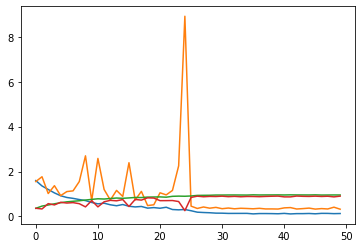

In [28]:
plt.plot(hist)

In [29]:
model = torch.load('exploss/sVGG_exploss_samelabelsmask_model.pt')

running_valloss = 0.0
running_valacc = 0.0
exp_features = []
exp_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs,_, features = model(inputs, labels)
    
    with torch.no_grad():
        exp_features.append(features.detach().cpu())
        exp_labels.append(labels.detach().cpu())

    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.4f | Avg. val_acc: %.4f' % (running_valloss / len(test_loader.dataset), running_valacc / len(test_loader.dataset)))


- Avg. val_loss: 0.2685 | Avg. val_acc: 0.9156


In [30]:
exp_features = torch.cat(exp_features, axis=0)
exp_labels = torch.cat(exp_labels)

exp_features.size()

torch.Size([3589, 512])

(<Figure size 1080x720 with 1 Axes>, array([[ 28.904331 ,  24.477163 ],
        [-15.167688 ,  35.431137 ],
        [-47.13176  ,   5.4565144],
        ...,
        [-12.753827 ,   5.472374 ],
        [-42.73631  , -53.34382  ],
        [ 11.850804 , -18.612667 ]], dtype=float32))

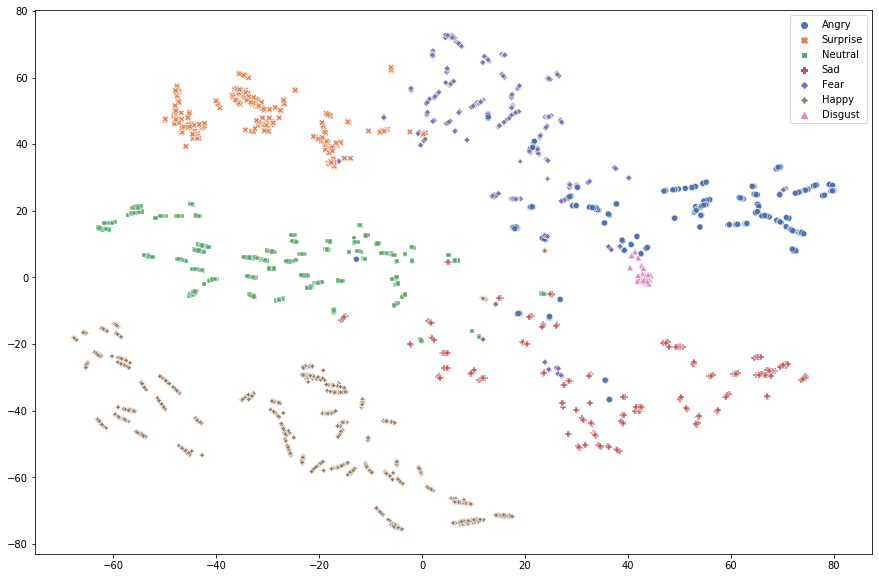

In [33]:
visualize_embedding(exp_features.numpy(), exp_labels.numpy(), label_dict=label_dict, save_path='exploss/sVGG_exploss_samelabelsmask_tsne.png')